In [1]:
from collections import OrderedDict
import copy
from google.colab import drive
from IPython.display import display
import matplotlib
matplotlib.rcParams['figure.figsize'] = [4, 3]
matplotlib.rcParams['font.size'] = 8
from matplotlib.ticker import PercentFormatter
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from torch import manual_seed, nn, norm, ones_like, optim, tensor
from torch.autograd import grad, Variable
from torch.nn.functional import softmax
from torch.utils.data import DataLoader, Dataset

In [2]:
!pip install pylogit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Note:** The `pylogit` library needs to be installed manually for Colab. To solve the error `cannot import name 'Iterable' from 'collections' (/usr/lib/python3.10/collections/__init__.py)`, we can replace `collections` with `collections.abc` in the file `/usr/local/lib/python3.10/dist-packages/pylogit/choice_tools.py`.

In [3]:
import pylogit as pl

In [4]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# CMAP Dataset

## Data import
We randomly sample 3000 OD pairs from the dataset, and use the first 90% of the data for training and the last 10% for testing.

In [5]:
size = 3000
X0 = pd.read_csv('/content/drive/My Drive/CMAP/X_std_new.csv', index_col=0).sample(size, random_state=0)
y = pd.read_csv('/content/drive/My Drive/CMAP/y_new.csv', index_col=0).sample(size, random_state=0)['mode_imputed']

train_size = int(size*.9)
X_train, y_train = X0[:train_size], y[:train_size]
X_test, y_test = X0[train_size:], y[train_size:]

X1 = pd.read_csv('/content/drive/My Drive/CMAP/X_ori_new.csv', index_col=0).sample(size, random_state=0)
cont_var = ['hhveh', 'auto_time', 'auto_cost', 'walk_time', 'train_time', 'train_cost', 'bike_time']
X1[cont_var].describe().round(decimals=2).T

,count,mean,std,min,25%,50%,75%,max
hhveh,3000.0,1.42,0.97,0.00,1.00,1.00,2.00,8.00
auto_time,3000.0,13.82,10.23,0.80,6.68,10.67,17.90,86.07
auto_cost,3000.0,11.81,5.20,1.25,8.32,8.42,15.14,81.24
walk_time,3000.0,113.79,144.19,3.23,30.72,61.08,132.52,1291.12
train_time,3000.0,60.24,84.46,3.23,22.87,38.50,62.10,946.33
train_cost,3000.0,2.56,0.39,0.00,2.38,2.42,2.52,7.25
bike_time,3000.0,34.65,43.21,1.18,9.83,18.78,40.37,390.72


## Data processing
1. Find a variable to visualize,
2. Build a dataframe with mean values, except for the above variable,
3. Build a dataframe with the same size for model regularity calculation, and
4. Load the data for training and testing.

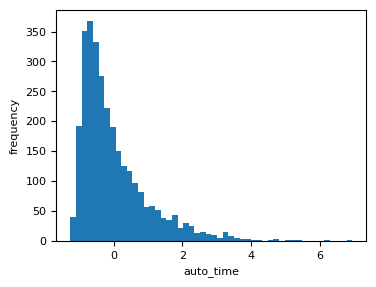

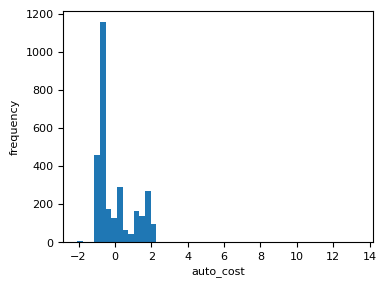

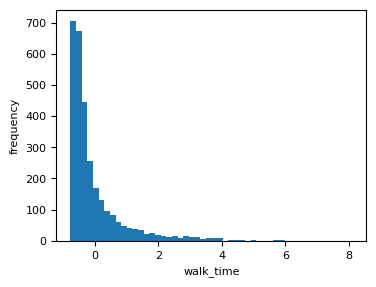

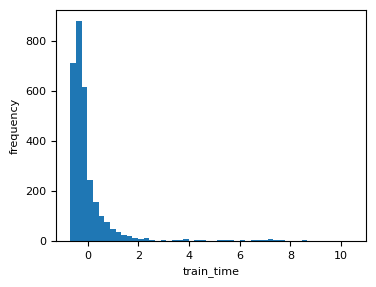

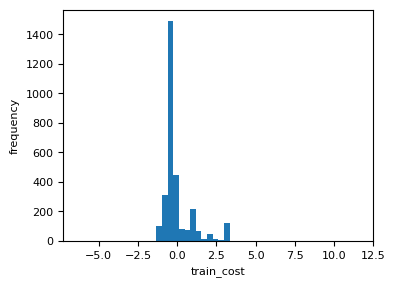

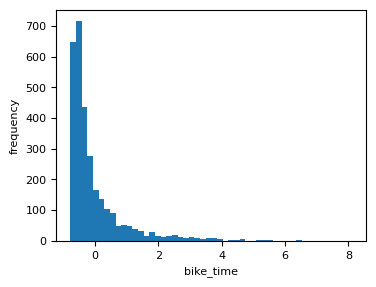

In [6]:
for i in ['auto_time', 'auto_cost', 'walk_time', 'train_time', 'train_cost', 'bike_time']:
    plt.hist(X0[i], bins=50)
    plt.xlabel(i)
    plt.ylabel('frequency')
    plt.show()

In [7]:
# The input to be visualized
var = 'auto_time'
alt = 0

In [8]:
upper, lower = X_train[var].max(), X_train[var].min()
X_prb = pd.DataFrame(np.zeros((51, len(X0.columns))), columns=X0.columns)
X_prb[var] = np.linspace(lower, upper, len(X_prb))
y_prb = pd.Series([np.random.randint(0, 4) for i in range(len(X_prb))], name='mode_imputed')

In [9]:
X_reg = X0.copy()
X_reg = X_reg.loc[X_reg.index.repeat(2)]
num_var = X_reg.columns.get_loc(var)
X_reg.iloc[np.arange(1, len(X_reg), 2), num_var] += (upper-lower) / 50
y_reg = pd.Series([np.random.randint(0, 4) for i in range(len(X_reg))], name='mode_imputed')

In [10]:
class Load_data(Dataset):
    'Class to load the training, test, and plotting sets'
    def __init__(self, x_set, y_set):
        self.X = Variable(tensor(x_set.values).float(), requires_grad=True)
        self.y = tensor(y_set.values)
    def __getitem__(self, index):
        return self.X[index], self.y[index]
    def __len__(self):
        return len(self.X)

train_loader = DataLoader(Load_data(X_train, y_train), batch_size=size//10, shuffle=True)
test_loader = DataLoader(Load_data(X_test, y_test), batch_size=len(X_test))

# Datasets for model analysis
share_loader = DataLoader(Load_data(X_train, y_train), batch_size=len(X_train))
prb_loader = DataLoader(Load_data(X_prb, y_prb), batch_size=len(X_prb))
reg_loader = DataLoader(Load_data(X_reg, y_reg), batch_size=len(X_reg))

## True market shares

In [11]:
ls_alt = ['Auto', 'Walk', 'Train', 'Bike']

def true_share(y):
    'Function to calculate the true market shares'
    share = pd.DataFrame(y.value_counts(normalize=True)*100).rename(columns={'mode_imputed': 'Share'}).round(decimals=1)
    share = share.astype(str).add('%')
    share.insert(0, 'Mode', ls_alt)
    return share

In [12]:
# Training set
true_share(y_train)

,Mode,Share
0,Auto,69.7%
1,Walk,18.3%
2,Train,10.1%
3,Bike,1.9%


In [13]:
# Testing set
true_share(y_test)

,Mode,Share
0,Auto,69.7%
1,Walk,18.0%
2,Train,10.3%
3,Bike,2.0%


# Multinomial Logit (MNL)
We estimate the MNL model as a baseline for model comparison.

## Data processing
The MNL model is estimated based on unnormalized inputs and a data frame with wide format.

In [14]:
def convert(X, y):
    'Function for data format conversion'
    X_wd = X.merge(y, left_index=True, right_index=True).reset_index(names='obs_id')
    for a in ['auto', 'walk', 'train', 'bike']:
        X_wd[f'ava_{a}'] = 1
    # Individual-specific variables
    ind_vars = X.columns.tolist()[:4]
    # Alternative-specific variables
    alt_vars = {u'time': dict([(0, 'auto_time'), (1, 'walk_time'), (2, 'train_time'), (3, 'bike_time')]),
                u'cost': dict([(0, 'auto_cost'), (2, 'train_cost')])}
    # Availability variables
    ava_vars = {0: 'ava_auto', 1: 'ava_walk', 2: 'ava_train', 3: 'ava_bike'}
    # Observation ID column
    X_wd['obs_id'] = np.arange(X_wd.shape[0], dtype=int) + 1
    # Wide format -> long format
    X_lg = pl.convert_wide_to_long(X_wd, ind_vars, alt_vars, ava_vars, 'obs_id', 'mode_imputed', 'alt_id')
    return X_lg

In [15]:
X1_train, X1_test = X1[:train_size], X1[train_size:]
X1_train_lg = convert(X1_train, y_train)
X1_train_lg

,obs_id,alt_id,mode_imputed,adt,sex,h_inc,hhveh,time,cost
0,1,0,1,1,0,0,0,6.683333,7.5898
1,1,1,0,1,0,0,0,31.400000,0.0000
2,1,2,0,1,0,0,0,30.033333,2.3200
3,1,3,0,1,0,0,0,9.716667,0.0000
4,2,0,1,1,1,1,1,16.033333,17.1636
...,...,...,...,...,...,...,...,...,...
10795,2699,3,0,1,1,1,1,82.083333,0.0000
10796,2700,0,1,1,0,1,1,8.116667,7.5898
10797,2700,1,0,1,0,1,1,28.516667,0.0000
10798,2700,2,0,1,0,1,1,26.183333,2.4000


## Model structure
The observed utilities are specified as follows:

\begin{align}
V_a &= \beta_{\mathrm{time},a} \mathrm{time}_a + \beta_{\mathrm{cost},a} \mathrm{cost}_a \\
V_w &= \beta_{0,w} + \beta_{\mathrm{adt},w} \mathrm{adt} + \beta_{\mathrm{hinc},w} \mathrm{hinc} + \beta_{\mathrm{veh},w} \mathrm{veh} + \beta_{\mathrm{time},w} \mathrm{time}_w \\
V_t &= \beta_{0,t} + \beta_{\mathrm{adt},t} \mathrm{adt} + \beta_{\mathrm{hinc},t} \mathrm{hinc} + \beta_{\mathrm{veh},t} \mathrm{veh} + \beta_{\mathrm{time},t} \mathrm{time}_t + \beta_{\mathrm{cost},t} \mathrm{cost}_t \\
V_b &= \beta_{0,b} + \beta_{\mathrm{adt},b} \mathrm{adt} + \beta_{\mathrm{hinc},b} \mathrm{hinc} + \beta_{\mathrm{veh},b} \mathrm{veh} + \beta_{\mathrm{time},b} \mathrm{time}_b
\end{align}

In [16]:
spec = OrderedDict()
name = OrderedDict()

# Alternative-specific constants
spec['intercept'] = [1, 2, 3]
name['intercept'] = ['asc_walk', 'asc_train', 'asc_bike']

# Individual-specific variables
spec['adt'] = [1, 2, 3]
name['adt'] = ['adt_walk', 'adt_train', 'adt_bike']
spec['sex'] = [1, 2, 3]
name['sex'] = ['sex_walk', 'sex_train', 'sex_bike']
spec['h_inc'] = [1, 2, 3]
name['h_inc'] = ['inc_walk', 'inc_train', 'inc_bike']
spec['hhveh'] = [1, 2, 3]
name['hhveh'] = ['veh_walk', 'veh_train', 'veh_bike']

# Alternative-specific variables
spec['time'] = [0, 1, 2, 3]
name['time'] = ['time_auto', 'time_walk', 'time_train', 'time_bike']
spec['cost'] = [0, 2]
name['cost'] = ['cost_auto', 'cost_train']

## Parameter estimation

In [17]:
mnl = pl.create_choice_model(X1_train_lg, alt_id_col='alt_id', obs_id_col='obs_id', choice_col='mode_imputed',
                             specification=spec, model_type='MNL', names=name)
mnl.fit_mle(np.zeros(21))
mnl.get_statsmodels_summary()

Log-likelihood at zero: -3,742.9948
Initial Log-likelihood: -3,742.9948


/usr/local/lib/python3.10/dist-packages/scipy/optimize/_minimize.py:554: RuntimeWarning: Method BFGS does not use Hessian information (hess).
  warn('Method %s does not use Hessian information (hess).' % method,


Estimation Time for Point Estimation: 0.25 seconds.
Final log-likelihood: -1,986.1337


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                mode_imputed   No. Observations:                2,700
Model:             Multinomial Logit Model   Df Residuals:                    2,679
Method:                                MLE   Df Model:                           21
Date:                     Fri, 09 Jun 2023   Pseudo R-squ.:                   0.469
Time:                             13:18:24   Pseudo R-bar-squ.:               0.464
AIC:                             4,014.267   Log-Likelihood:             -1,986.134
BIC:                             4,138.189   LL-Null:                    -3,742.995
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
asc_walk      -1.0521      0.417     -2.523      0.012      -1.870      -0.235
asc_train     -2.3914      0.964     -2.480      0.013      -4.281      -0.501
asc_bike      -2.8094      0.720     -3.900      0.000      -4.221      -1.398
adt_walk       0.2504      0.381      0.656      0.512      -0.497       0.998
adt_train      1.1644      0.738      1.577      0.115      -0.283       2.612
adt_bike      -1.0841      0.640     -1.694      0.090      -2.338       0.170
sex_walk       0.6579      0.111      5.903      0.000       0.439       0.876
sex_train      0.4183      0.140      2.988      0.003       0.144       0.693
sex_bike       1.4621      0.325      4.494      0.000       0.824       2.100
inc_walk       0.6354      0.126      5.036      0.000       0.388       0.883
inc_train      0.8013      0.160      5.006      0.000       0.488       1.115
inc_bike       0.7599      0.331      2.294      0.022       0.111       1.409
veh_walk      -0.9410      0.078    -12.048      0.000      -1.094      -0.788
veh_train     -1.0288      0.103    -10.033      0.000      -1.230      -0.828
veh_bike      -1.4228      0.220     -6.455      0.000      -1.855      -0.991
time_auto     -0.0804      0.012     -6.800      0.000      -0.104      -0.057
time_walk     -0.0189      0.002    -11.572      0.000      -0.022      -0.016
time_train    -0.0315      0.004     -7.604      0.000      -0.040      -0.023
time_bike     -0.0329      0.007     -5.015      0.000      -0.046      -0.020
cost_auto     -0.0469      0.018     -2.539      0.011      -0.083      -0.011
cost_train    -0.1213      0.284     -0.427      0.669      -0.678       0.435
==============================================================================
"""

## Results

In [18]:
def mnl_share(X):
    'Function to calculate the MNL market shares'
    prb = sum(mnl.predict(X).reshape(len(X)//4, 4)) / (len(X)//4)
    share = pd.DataFrame(prb*100, columns=['Share']).round(decimals=1).astype(str).add('%')
    share.insert(0, 'Mode', ls_alt)
    return share

In [19]:
# Training set
mnl_share(X1_train_lg)

,Mode,Share
0,Auto,69.7%
1,Walk,18.3%
2,Train,10.1%
3,Bike,1.9%


In [20]:
# Testing set
X1_test_lg = convert(X1_test, y_test)
mnl_share(X1_test_lg)

,Mode,Share
0,Auto,69.1%
1,Walk,19.4%
2,Train,9.7%
3,Bike,1.8%


In [21]:
def mnl_els_ind(beta, x, prb, idx):
    'Function to calculate MNL elasticities w.r.t. individual-specific variables'
    # For the reference alternative
    els = -x * (beta[0]*prb[:, 1] + beta[1]*prb[:, 2] + beta[2]*prb[:, 3])
    # For other alternatives
    if idx != 0:
        els += x * beta[idx-1]
    return str(np.mean(els).round(3)) + ' (' + str(np.std(els).round(1)) + ')'

def mnl_els_alt(beta, x, prb, kind):
    'Function to calculate MNL elasticities w.r.t. alternative-specific variables'
    # Cross-elasticity
    els = -beta * x * prb
    # Self-elasticity
    if kind == 1:
        els = beta * x * (1-prb)
    return str(np.mean(els).round(3)) + ' (' + str(np.std(els).round(1)) + ')'

In [22]:
prb = mnl.predict(X1_test_lg).reshape(len(X1_test_lg)//4, 4)
acc = (prb.argmax(1) == y_test).sum() / len(y_test)
print(f'Accuracy = {acc*100:.1f}%')

Accuracy = 71.3%


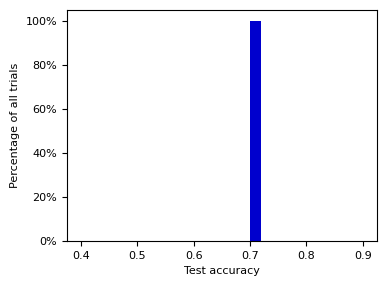

In [23]:
# Plot the histogram of test accuracies
plt.hist(acc, bins=25, range=(.4, .9), color='mediumblue')
plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
plt.xlabel('Test accuracy')
plt.ylabel('Percentage of all trials')
plt.show()

In [24]:
# Elasticities w.r.t. individual-specific variables
els_ind = pd.DataFrame(np.zeros((1, 4)))
for i in range(4):
    els_ind.loc[0, i] = mnl_els_ind(mnl.params[12:15], X1_test['hhveh'], prb, i)

# Elasticities w.r.t. alternative-specific variables
self_alt = [[1, 1, 0, 0, 0, 0], [0, 0, 1, 0, 0, 0], [0, 0, 0, 1, 1, 0], [0, 0, 0, 0, 0, 1]]
els_alt = pd.DataFrame(np.zeros((6, 4)))
for i in range(4):
    els_alt.loc[0, i] = mnl_els_alt(mnl.params[15], X1_test['auto_time'], prb[:, i], self_alt[i][0])
    els_alt.loc[1, i] = mnl_els_alt(mnl.params[19], X1_test['auto_cost'], prb[:, i], self_alt[i][1])
    els_alt.loc[2, i] = mnl_els_alt(mnl.params[16], X1_test['walk_time'], prb[:, i], self_alt[i][2])
    els_alt.loc[3, i] = mnl_els_alt(mnl.params[17], X1_test['train_time'], prb[:, i], self_alt[i][3])
    els_alt.loc[4, i] = mnl_els_alt(mnl.params[20], X1_test['train_cost'], prb[:, i], self_alt[i][4])
    els_alt.loc[5, i] = mnl_els_alt(mnl.params[18], X1_test['bike_time'], prb[:, i], self_alt[i][5])

els = pd.concat([els_ind, els_alt]).reset_index(drop=True)
els.columns = ls_alt
els.insert(0, 'Input', cont_var)
els

,Input,Auto,Walk,Train,Bike
0,hhveh,0.257 (0.2),-1.07 (1.0),-1.194 (1.0),-1.749 (1.5)
1,auto_time,-0.267 (0.2),0.145 (0.1),0.104 (0.2),0.018 (0.0)
2,auto_cost,-0.145 (0.1),0.084 (0.1),0.052 (0.1),0.009 (0.0)
3,walk_time,1.794 (2.9),-1.996 (3.0),0.176 (0.4),0.026 (0.0)
4,train_time,1.551 (2.8),0.203 (0.2),-1.779 (2.9),0.025 (0.0)
5,train_cost,0.219 (0.1),0.057 (0.0),-0.282 (0.1),0.005 (0.0)
6,bike_time,0.955 (1.6),0.098 (0.1),0.097 (0.2),-1.149 (1.6)


In [25]:
upper1, lower1 = X1_train[var].max(), X1_train[var].min()
X1_prb = pd.DataFrame(np.tile(X1.mean(), (51, 1)), columns=X1.columns)
X1_prb[var] = np.linspace(lower1, upper1, len(X1_prb))

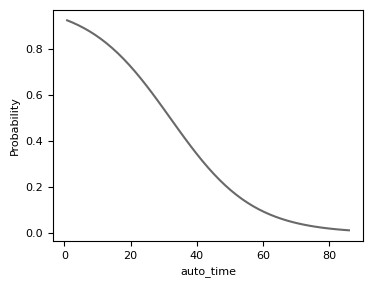

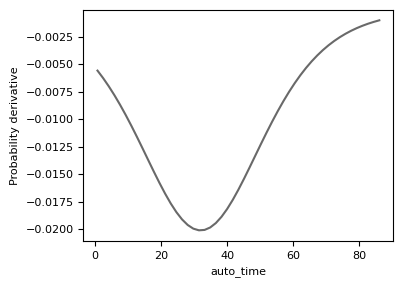

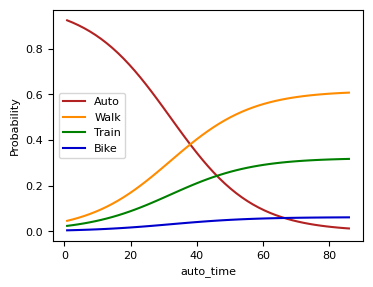

In [26]:
X1_prb_lg = convert(X1_prb, y_prb)
ls1_prb = mnl.predict(X1_prb_lg).reshape(len(X1_prb_lg)//4, 4)
ls1_grd = mnl.params[15] * ls1_prb[:, alt] * (1-ls1_prb[:, alt])

# Plot probabilities
plt.plot(X1_prb[var], ls1_prb[:, alt], color='dimgrey')
plt.xlabel(f'{var}')
plt.ylabel('Probability')
plt.show()
# Plot probability derivatives
plt.plot(X1_prb[var], ls1_grd, color='dimgrey')
plt.xlabel(f'{var}')
plt.ylabel('Probability derivative')
plt.show()
# Plot substitution patterns
ls_color = ['firebrick', 'darkorange', 'green', 'mediumblue']
for a in range(4):
    plt.plot(X1_prb[var], ls1_prb[:, a], color=ls_color[a], label=ls_alt[a])
plt.legend(loc='center left')
plt.xlabel(f'{var}')
plt.ylabel('Probability')
plt.show()

In [27]:
X1_reg = X1.copy()
X1_reg = X1_reg.loc[X1_reg.index.repeat(2)]
X1_reg.iloc[np.arange(1, len(X1_reg), 2), num_var] += (upper1-lower1) / 50

X1_reg_lg = convert(X1_reg, y_reg)
ls1_reg = mnl.predict(X1_reg_lg).reshape(len(X1_reg_lg)//4, 4)[:, alt]

In [28]:
def cal_reg(ls_reg):
    eps = 5e-4
    diff = np.subtract(ls_reg[::2], ls_reg[1::2])
    diff_st = [(d > eps).astype(int) for d in diff]
    diff_wk = [(d > -eps).astype(int) for d in diff]
    reg_st = sum(diff_st) / len(diff_st)
    reg_wk = sum(diff_wk) / len(diff_wk)
    print(f'Strong regularity = {reg_st:.4f}')
    print(f'Weak regularity = {reg_wk:.4f}')
    return reg_st, reg_wk

In [29]:
reg_st, reg_wk = cal_reg(ls1_reg)

Strong regularity = 1.0000
Weak regularity = 1.0000


# Deep neural network (DNN)

## Model structure
Here we apply a simple DNN with 3 hidden layers $\times$ 100 neurons. In order to improve the model regularity, we include 3 types of gradient regularizers in the loss function during training:
- gradient of alt utlities w.r.t. inputs,
- gradient of alt probabilities w.r.t. inputs, and
- gradient of the cross-entropy loss w.r.t. inputs.

We do not consider the cross-effect of inputs on choice probabilities.

Then, each of the above regularizer is added to the loss function in terms of
- sum: simply summing up all elements, and
- norm: finding the Frobenius norm of a matrix or vector.

Note that using sums can hopefully improve both strong and weak regularities, while using norms may improve the weak regularity.

In [30]:
class DNN(nn.Module):
    'Class of DNNs'
    def __init__(self):
        super(DNN, self).__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),   
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, 4)
        )

    def forward(self, x):
        return self.linear_relu_stack(x)

## Model training
We train each model 30 times and take the average results of 10 models for analysis.

In [31]:
def cal_loss(model, X, y, regularizer, sum, lambd, criterion):
    'Function to regularize the loss function'
    'lambd is the weight of regularizer -> (1-lambd) is the weight of loss'
    'sum is an indicator of regularizing summation'
    loss = criterion(model(X), y)
    # Utility gradient regularizer
    if regularizer == 'util':
        utl = model(X)
        g_a = grad(utl[:, 0], X, ones_like(utl[:, 0]), create_graph=True)[0][:, [4, 5]]
        g_w = grad(utl[:, 1], X, ones_like(utl[:, 1]), create_graph=True)[0][:, 6]
        g_t = grad(utl[:, 2], X, ones_like(utl[:, 2]), create_graph=True)[0][:, [7, 8]]
        g_b = grad(utl[:, 3], X, ones_like(utl[:, 3]), create_graph=True)[0][:, 9]
    # Probability gradient regularizer
    elif regularizer == 'prob':
        prb = softmax(model(X), dim=1)
        g_a = grad(prb[:, 0], X, ones_like(prb[:, 0]), create_graph=True)[0][:, [4, 5]]
        g_w = grad(prb[:, 1], X, ones_like(prb[:, 1]), create_graph=True)[0][:, 6]
        g_t = grad(prb[:, 2], X, ones_like(prb[:, 2]), create_graph=True)[0][:, [7, 8]]
        g_b = grad(prb[:, 3], X, ones_like(prb[:, 3]), create_graph=True)[0][:, 9]
    # Loss gradient regularizer
    elif regularizer == 'loss':
        g_a = -grad(loss, X, create_graph=True)[0][:, [4, 5]]
        g_w = -grad(loss, X, create_graph=True)[0][:, 6]
        g_t = -grad(loss, X, create_graph=True)[0][:, [7, 8]]
        g_b = -grad(loss, X, create_graph=True)[0][:, 9]
    else:
        return loss
    # Compute the regularizer
    if sum:
        reg = g_a.sum() + g_w.sum() + g_t.sum() + g_b.sum()
    else:
        reg = norm(g_a) + norm(g_w) + norm(g_t) + norm(g_b)
    return (1-lambd) * loss + lambd * reg

In [32]:
def train_loop(model, regularizer, sum, lambd, optimizer, criterion):
    'Function for DNN training in each epoch'
    for batch, (X, y) in enumerate(train_loader):
        loss = cal_loss(model, X, y, regularizer, sum, lambd, criterion)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

We use standardized inputs in DNN training:

\begin{equation}
x' = \frac{x-\bar{x}}{\sigma_x}
\end{equation}

Hence the elasticity is computed approximately as follows:

\begin{equation}
\varepsilon = \frac{\partial s}{\partial x}\frac{x}{s} = \frac{\partial s}{\partial x'}\frac{\partial x'}{\partial x}\frac{x}{s} \approx \frac{\partial s}{\partial x'}\frac{1}{\sigma_x}\frac{\sigma_x x'+\bar{x}}{s} = \frac{\partial s}{\partial x'}\left(x' + \frac{\bar{x}}{\sigma_x}\right)\frac{1}{s}
\end{equation}

In [33]:
def test(model, criterion):
    'Function for DNN testing'
    # For loss, accuracy, elasticity, and market share (testing set) calculation
    els = []
    for X, y in test_loader:
        pred = model(X)
        loss = criterion(pred, y).item()
        cor = (pred.argmax(1) == y).float().sum()
        share_test = softmax(pred, dim=1).detach().numpy()
        p = softmax(pred, dim=1)
        for a in range(4):
            gr = grad(p[:, a], X, ones_like(p[:, a]), create_graph=True)[0].detach().numpy()
            pr = np.tile(p[:, a].detach().numpy(), (len(X0.columns), 1)).T
            corr = np.tile(X1.mean()/X1.std(), (len(X), 1))
            els.append(gr/pr * (X.detach().numpy()+corr))
    loss /= len(test_loader)
    acc = cor / len(test_loader.dataset)
    # For market share (training set) calculation
    for X, _ in share_loader:
        share_train = softmax(model(X), dim=1).detach().numpy()
    # For probability and gradient calculation
    for X, _ in prb_loader:
        p = softmax(model(X), dim=1)
        prb = p.detach().numpy()
        grd = grad(p[:, alt], X, ones_like(p[:, alt]), create_graph=True)[0][:, num_var].detach().numpy()
    # For regularity calculation
    for X, _ in reg_loader:
        reg = softmax(model(X), dim=1)[:, alt].detach().numpy()
    return loss, acc, share_train, share_test, els, prb, grd, reg

In [34]:
def train_DNN(regularizer, sum, lambd):
    'Function for DNN training (10 models * 30 epochs)'
    ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb, ls_grd, ls_reg = [[] for i in range(7)]
    for m in range(10):
        manual_seed(m)
        model = DNN()
        optimizer = optim.Adam(model.parameters())
        criterion = nn.CrossEntropyLoss()
        for i in range(30):
            train_loop(model, regularizer, sum, lambd, optimizer, criterion)
        loss, acc, share_train, share_test, els, prb, grd, reg = test(model, criterion)
        [x.append(y) for x, y in zip([ls_loss, ls_acc, ls_share_ts, ls_share_tr, ls_prb,
                                      ls_grd], [loss, acc, share_train, share_test, prb, grd])]
        ls_reg.extend(reg)
        # Record elasticities of only one model
        if loss == min(ls_loss):
            ls_els = els
        print(f'Model {m+1:<2}: {loss:.4f}, {acc*100:.1f}%')
    return ls_loss, ls_acc, ls_share_tr, ls_share_ts, ls_els, np.array(ls_prb), ls_grd, ls_reg

## Functions for analysis
We evaluate the models by:
- test losses and accuracies,
- market shares of modes,
- strong and weak regularities, and
- elasticities of modes w.r.t. inputs.

In [35]:
def dnn_agg(ls_loss, ls_acc):
    'Function to analyze aggregate DNN performance'
    mean_loss, mean_acc = np.mean(ls_loss), np.mean(ls_acc)
    print(f'Mean loss = {mean_loss:.4f}')
    print(f'Mean accuracy = {mean_acc*100:.1f}%')
    agg_loss, agg_acc = mean_loss, mean_acc
    # Plot the histogram of test accuracies
    plt.hist(ls_acc, bins=25, range=(.4, .9), weights=np.ones(len(ls_acc))/len(ls_acc), color='mediumblue')
    plt.gca().yaxis.set_major_formatter(PercentFormatter(1, 0))
    plt.xlabel('Test accuracy')
    plt.ylabel('Percentage of all trials')
    plt.show()
    return agg_loss, agg_acc

In [36]:
def dnn_share(ls_share):
    'Function to analyze DNN market shares of modes'
    share = [sum(s)/len(s) for s in ls_share]
    avg_share = np.mean(share, 0) * 100
    std_share = np.std(share, 0) * 100
    df_avg = pd.DataFrame(avg_share).round(decimals=1)
    df_std = pd.DataFrame(std_share).round(decimals=1)
    df = df_avg.astype(str).add('% (').add(df_std.astype(str)).add('%)')
    df.columns = ['Share']
    df.insert(0, 'Mode', ls_alt)
    display(df)

In [37]:
def dnn_els(ls_els):
    'Function to analyze DNN elasticities of modes w.r.t. inputs'
    avg_els = np.nanmean(ls_els, 1).T
    std_els = np.nanstd(ls_els, 1).T
    df_avg = pd.DataFrame(avg_els).round(decimals=3)
    df_std = pd.DataFrame(std_els).round(decimals=1)
    df = df_avg.astype(str).add(' (').add(df_std.astype(str)).add(')')
    df = df.iloc[3:, :]
    df.columns = ls_alt
    df.insert(0, 'Input', cont_var)
    display(df)

In [38]:
def dnn_sub(ls_prb, ls_grd):
    'Function to analyze DNN prabilities, probability derivatives, and substitution patterns'
    # Plot probabilities
    for p in ls_prb[:, :, alt]:
        plt.plot(X1_prb[var], p, color='dimgrey', alpha=.15)
    plt.plot(X1_prb[var], np.mean(ls_prb[:, :, alt], axis=0), color='dimgrey')
    plt.xlabel(f'{var}')
    plt.ylabel('Probability')
    plt.show()
    # Plot probability derivatives
    for p in ls_grd:
        plt.plot(X1_prb[var], p, color='dimgrey', alpha=.15)
    plt.plot(X1_prb[var], np.mean(ls_grd, axis=0), color='dimgrey')
    plt.xlabel(f'{var}')
    plt.ylabel('Probability derivative')
    plt.show()
    # Plot substitution patterns
    for a in range(4):
        for p in ls_prb[:, :, a]:
            plt.plot(X1_prb[var], p, color=ls_color[a], alpha=.15)
        plt.plot(X1_prb[var], np.mean(ls_prb[:, :, a], axis=0), color=ls_color[a], label=ls_alt[a])
    plt.legend(loc='center left')
    plt.xlabel(f'{var}')
    plt.ylabel('Probability')
    plt.show()

In [39]:
def comparison(lambdas, agg_loss, agg_acc, ls_st, ls_wk):
    'Function to compare DNN models'
    if len(lambdas) == 1:
        return
    print('-'*30, '\nModel comparison:')
    # Plot test losses
    plt.grid(linestyle='--', color='lightgrey')
    plt.plot(np.log10(lambdas), agg_loss, marker='.', color='mediumblue')
    plt.xlabel(r'$\lg(\lambda)$')
    plt.ylabel('Test loss')
    plt.show()
    # Plot test accuracies
    plt.grid(linestyle='--', color='lightgrey')
    plt.plot(np.log10(lambdas), agg_acc, marker='.', color='mediumblue')
    plt.xlabel(r'$\lg(\lambda)$')
    plt.ylabel('Test accuracy')
    plt.show()
    # Plot regularities
    plt.grid(linestyle='--', color='lightgrey')
    plt.plot(np.log10(lambdas), ls_st, marker='.', color='mediumblue', label='Strong')
    plt.plot(np.log10(lambdas), ls_wk, marker='.', color='darkorange', label='Weak')
    plt.xlabel(r'$\lg(\lambda)$')
    plt.ylabel('Model regularity')
    plt.legend(loc='upper left')

In [45]:
def result(regularizer, lambdas=[0], sum=True):
    'Function to display all DNN results'
    agg_loss, agg_acc, ls_st, ls_wk = [[] for i in range(4)]
    for lambd in lambdas:
        print('Penalty =', lambd)
        # Individual losses and accuracies
        print('-'*30, '\nTest losses and accuracies:')
        ls_loss, ls_acc, ls_share_tr, ls_share_ts, ls_els, ls_prb, ls_grd, ls_reg = train_DNN(regularizer, sum, lambd)
        # Mean loss and accuracy
        print('-'*30)
        [x.append(y) for x, y in zip([agg_loss, agg_acc], dnn_agg(ls_loss, ls_acc))]
        # Market shares
        print('-'*30, '\nTraining set:')
        dnn_share(ls_share_tr)
        print('-'*30, '\nTesting set:')
        dnn_share(ls_share_ts)
        # Elasticities
        print('-'*30, '\nElasticities:')
        dnn_els(ls_els)
        # Regularities
        print('-'*30)
        reg_st, reg_wk = cal_reg(ls_reg)
        # Substitution patterns
        print('-'*30)
        dnn_sub(ls_prb, ls_grd)
        [x.append(y) for x, y in zip([ls_st, ls_wk], [reg_st, reg_wk])]
    comparison(lambdas, agg_loss, agg_acc, ls_st, ls_wk)

## Results

### Without regularization

Penalty = 0
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7470, 70.3%
Model 2 : 0.7467, 71.3%
Model 3 : 0.7417, 71.7%
Model 4 : 0.7430, 72.7%
Model 5 : 0.7354, 73.0%
Model 6 : 0.7575, 71.3%
Model 7 : 0.7509, 71.0%
Model 8 : 0.7444, 73.3%
Model 9 : 0.7485, 72.0%
Model 10: 0.7416, 73.3%
------------------------------
Mean loss = 0.7457
Mean accuracy = 72.0%


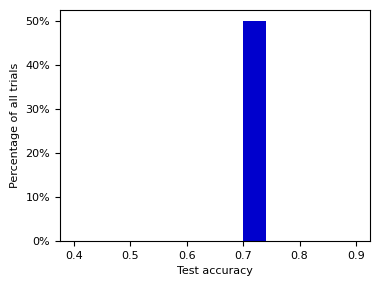

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.8%)
1,Walk,20.3% (1.8%)
2,Train,9.1% (0.5%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.7%)
1,Walk,18.0% (1.6%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.174 (0.3),-0.328 (0.8),-0.737 (0.6),-0.998 (0.7)
4,auto_time,-0.236 (0.4),0.248 (0.5),1.122 (0.6),0.636 (0.5)
5,auto_cost,-0.134 (0.3),0.18 (0.9),0.538 (0.9),-0.367 (1.2)
6,walk_time,0.165 (0.2),-0.61 (0.6),-0.341 (0.6),-0.366 (0.7)
7,train_time,0.423 (0.4),-1.469 (1.3),-1.804 (2.0),-1.488 (2.2)
8,train_cost,-0.594 (1.6),2.246 (2.3),-2.701 (2.2),-0.561 (1.7)
9,bike_time,-0.17 (0.4),0.504 (0.9),0.91 (1.0),0.779 (0.9)


------------------------------
Strong regularity = 0.8536
Weak regularity = 0.9058
------------------------------


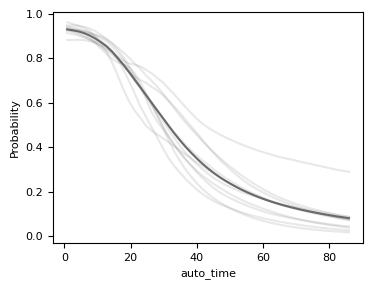

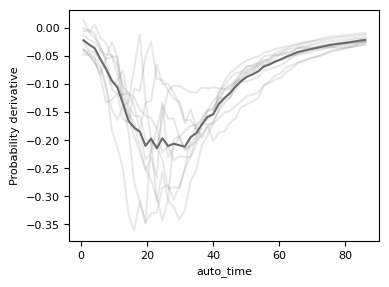

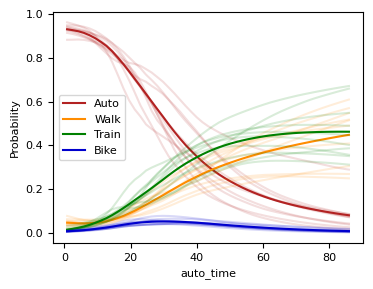

In [41]:
result('none')

### Utility gradient regularization

Penalty = 1.8e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7543, 68.3%
Model 2 : 0.7559, 71.3%
Model 3 : 0.7549, 71.0%
Model 4 : 0.7381, 72.3%
Model 5 : 0.7366, 71.7%
Model 6 : 0.7623, 71.0%
Model 7 : 0.7501, 71.0%
Model 8 : 0.7409, 71.3%
Model 9 : 0.7558, 72.3%
Model 10: 0.7503, 72.0%
------------------------------
Mean loss = 0.7499
Mean accuracy = 71.2%


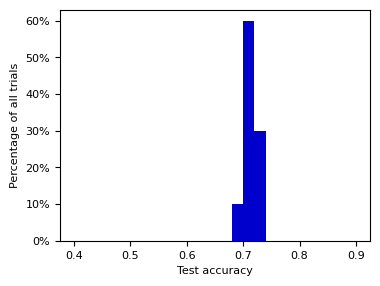

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.1% (1.8%)
1,Walk,20.9% (1.9%)
2,Train,9.2% (0.5%)
3,Bike,1.8% (0.0%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.9% (1.7%)
1,Walk,18.3% (1.7%)
2,Train,10.0% (0.5%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.164 (0.3),-0.261 (0.9),-0.636 (0.8),-1.042 (0.8)
4,auto_time,-0.395 (0.5),0.727 (0.8),1.879 (0.9),0.922 (0.7)
5,auto_cost,-0.477 (0.6),1.007 (1.2),1.849 (1.3),0.744 (1.3)
6,walk_time,0.267 (0.3),-1.195 (1.2),-0.53 (0.8),-0.374 (0.8)
7,train_time,0.493 (0.4),-1.456 (1.3),-2.992 (3.7),-1.138 (2.3)
8,train_cost,-0.263 (1.6),2.71 (3.1),-6.45 (4.3),0.941 (2.0)
9,bike_time,-0.151 (0.4),0.371 (0.9),0.914 (1.2),-0.128 (0.4)


------------------------------
Strong regularity = 0.9667
Weak regularity = 0.9878
------------------------------


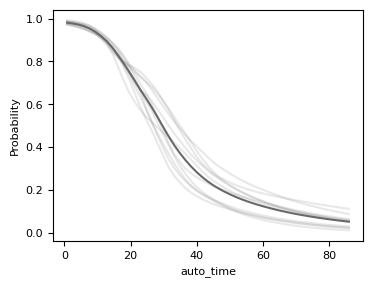

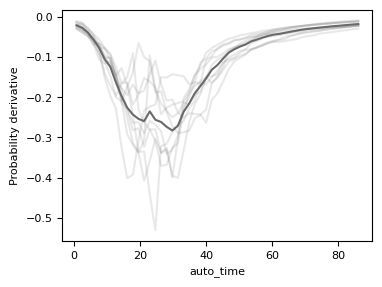

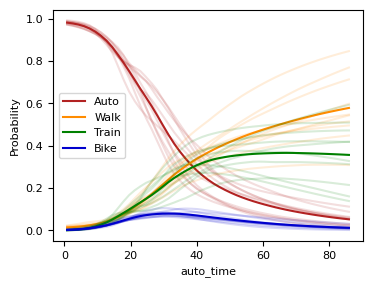

Penalty = 5.6e-06
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7453, 71.3%
Model 2 : 0.7438, 72.7%
Model 3 : 0.7428, 70.7%
Model 4 : 0.7385, 71.3%
Model 5 : 0.7341, 72.7%
Model 6 : 0.7584, 71.3%
Model 7 : 0.7484, 71.7%
Model 8 : 0.7409, 72.7%
Model 9 : 0.7475, 71.7%
Model 10: 0.7414, 72.7%
------------------------------
Mean loss = 0.7441
Mean accuracy = 71.9%


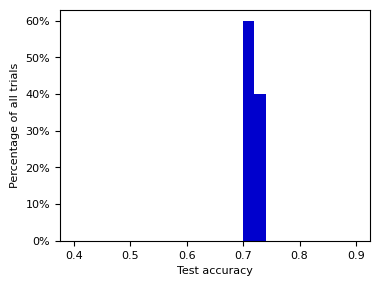

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.8%)
1,Walk,20.4% (1.8%)
2,Train,9.1% (0.5%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.7%)
1,Walk,18.0% (1.6%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.171 (0.3),-0.309 (0.8),-0.727 (0.7),-0.99 (0.7)
4,auto_time,-0.293 (0.4),0.407 (0.6),1.323 (0.6),0.729 (0.5)
5,auto_cost,-0.248 (0.4),0.465 (0.9),0.915 (1.0),0.012 (1.1)
6,walk_time,0.197 (0.3),-0.76 (0.8),-0.386 (0.6),-0.361 (0.7)
7,train_time,0.444 (0.4),-1.454 (1.3),-2.067 (2.3),-1.358 (2.2)
8,train_cost,-0.48 (1.5),2.327 (2.4),-3.497 (2.6),-0.257 (1.7)
9,bike_time,-0.159 (0.4),0.436 (0.8),0.873 (1.0),0.467 (0.6)


------------------------------
Strong regularity = 0.9115
Weak regularity = 0.9506
------------------------------


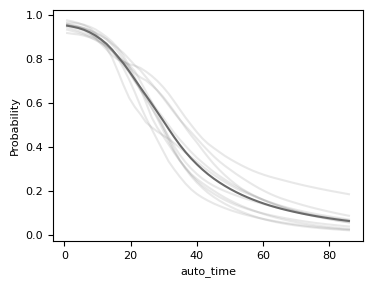

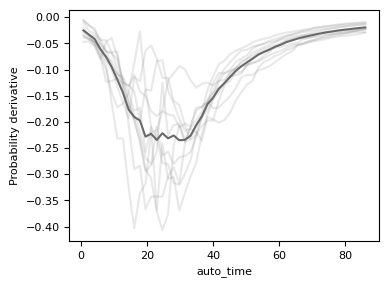

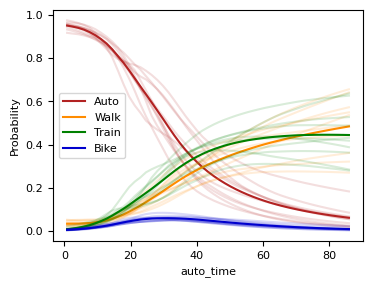

Penalty = 1.8e-06
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7449, 70.7%
Model 2 : 0.7461, 72.0%
Model 3 : 0.7413, 71.7%
Model 4 : 0.7408, 71.7%
Model 5 : 0.7342, 73.0%
Model 6 : 0.7600, 71.0%
Model 7 : 0.7490, 71.7%
Model 8 : 0.7447, 72.7%
Model 9 : 0.7473, 72.0%
Model 10: 0.7409, 73.0%
------------------------------
Mean loss = 0.7449
Mean accuracy = 71.9%


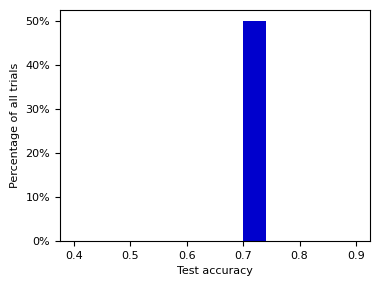

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.7%)
1,Walk,20.4% (1.7%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.0% (1.6%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.175 (0.3),-0.319 (0.8),-0.72 (0.7),-1.002 (0.7)
4,auto_time,-0.253 (0.4),0.287 (0.6),1.182 (0.6),0.665 (0.5)
5,auto_cost,-0.174 (0.3),0.272 (0.9),0.649 (0.9),-0.243 (1.1)
6,walk_time,0.174 (0.3),-0.659 (0.7),-0.366 (0.6),-0.37 (0.7)
7,train_time,0.429 (0.4),-1.476 (1.3),-1.891 (2.1),-1.456 (2.2)
8,train_cost,-0.543 (1.5),2.27 (2.4),-2.934 (2.4),-0.435 (1.7)
9,bike_time,-0.166 (0.4),0.492 (0.9),0.914 (1.1),0.688 (0.9)


------------------------------
Strong regularity = 0.8734
Weak regularity = 0.9227
------------------------------


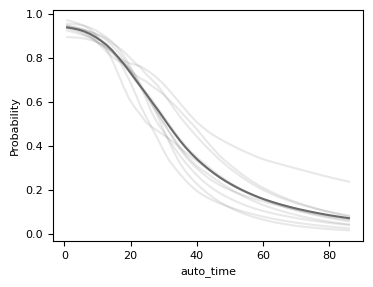

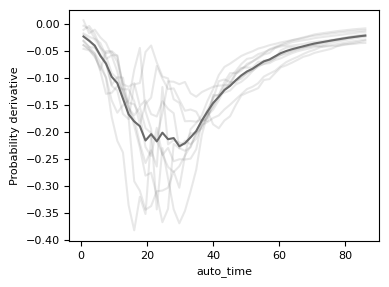

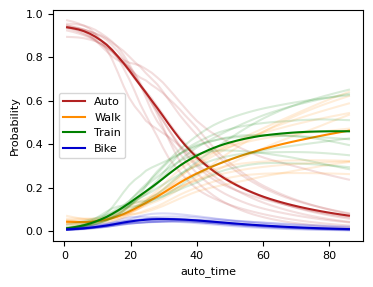

Penalty = 5.6e-07
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7447, 71.0%
Model 2 : 0.7447, 71.3%
Model 3 : 0.7411, 71.3%
Model 4 : 0.7425, 72.3%
Model 5 : 0.7367, 72.7%
Model 6 : 0.7580, 71.7%
Model 7 : 0.7493, 71.3%
Model 8 : 0.7449, 73.3%
Model 9 : 0.7480, 72.0%
Model 10: 0.7398, 73.0%
------------------------------
Mean loss = 0.7450
Mean accuracy = 72.0%


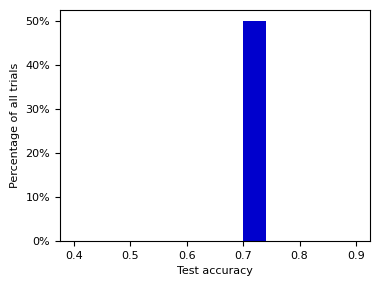

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.8% (1.7%)
1,Walk,20.4% (1.7%)
2,Train,9.1% (0.5%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.0% (1.5%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.174 (0.3),-0.339 (0.8),-0.735 (0.7),-1.036 (0.7)
4,auto_time,-0.242 (0.4),0.255 (0.5),1.139 (0.6),0.658 (0.5)
5,auto_cost,-0.157 (0.3),0.219 (0.9),0.611 (0.9),-0.314 (1.1)
6,walk_time,0.167 (0.2),-0.608 (0.6),-0.35 (0.6),-0.355 (0.7)
7,train_time,0.426 (0.4),-1.486 (1.4),-1.837 (2.1),-1.463 (2.2)
8,train_cost,-0.587 (1.6),2.223 (2.3),-2.802 (2.3),-0.636 (1.7)
9,bike_time,-0.169 (0.4),0.496 (0.9),0.911 (1.1),0.743 (0.9)


------------------------------
Strong regularity = 0.8569
Weak regularity = 0.9095
------------------------------


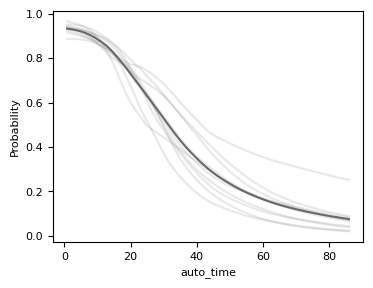

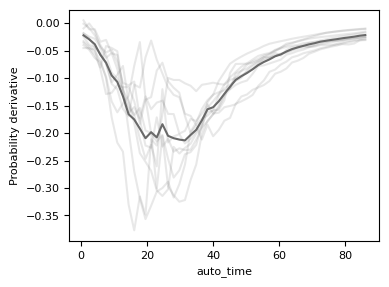

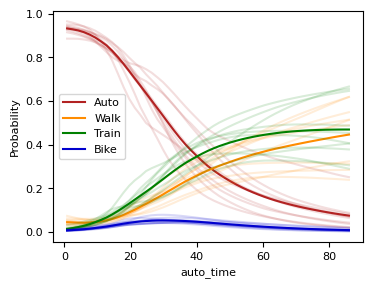

Penalty = 1.8e-07
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7460, 71.0%
Model 2 : 0.7457, 71.7%
Model 3 : 0.7422, 71.3%
Model 4 : 0.7421, 72.3%
Model 5 : 0.7369, 73.0%
Model 6 : 0.7580, 71.3%
Model 7 : 0.7503, 71.3%
Model 8 : 0.7445, 73.0%
Model 9 : 0.7481, 72.0%
Model 10: 0.7404, 72.7%
------------------------------
Mean loss = 0.7454
Mean accuracy = 72.0%


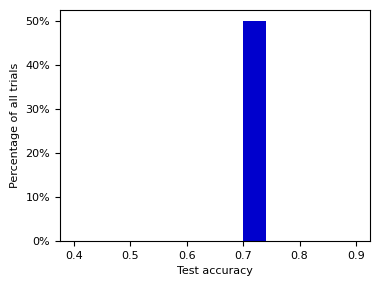

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.7%)
1,Walk,20.4% (1.7%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.0% (1.5%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.175 (0.3),-0.329 (0.8),-0.739 (0.6),-1.008 (0.7)
4,auto_time,-0.243 (0.4),0.26 (0.5),1.138 (0.6),0.65 (0.5)
5,auto_cost,-0.147 (0.3),0.218 (0.9),0.59 (0.9),-0.307 (1.1)
6,walk_time,0.166 (0.3),-0.609 (0.6),-0.341 (0.6),-0.367 (0.7)
7,train_time,0.423 (0.4),-1.474 (1.3),-1.82 (2.1),-1.492 (2.2)
8,train_cost,-0.569 (1.5),2.261 (2.3),-2.724 (2.2),-0.551 (1.7)
9,bike_time,-0.168 (0.4),0.495 (0.9),0.903 (1.0),0.762 (0.9)


------------------------------
Strong regularity = 0.8575
Weak regularity = 0.9089
------------------------------


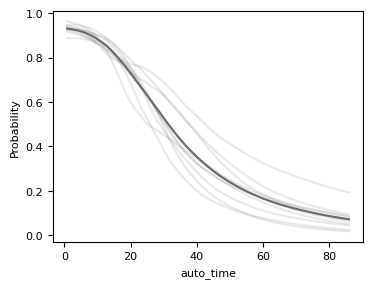

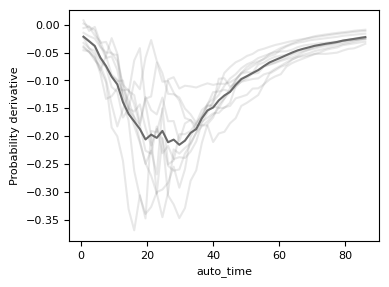

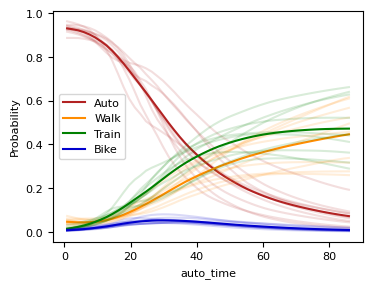

------------------------------ 
Model comparison:


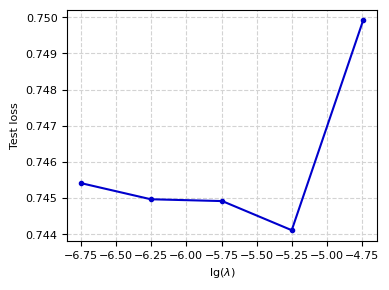

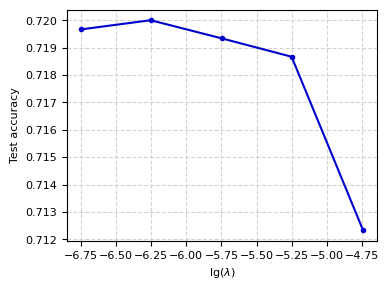

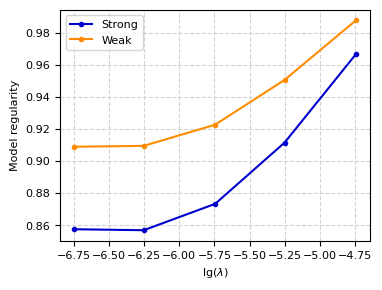

In [67]:
# With sum
result('util', [1.8e-5, 5.6e-6, 1.8e-6, 5.6e-7, 1.8e-7])

In [63]:
# With norm
# result('util', [1e-1, 1e-2, 1e-3], False)

### Probability gradient regularization

Penalty = 0.0001
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7490, 69.3%
Model 2 : 0.7553, 71.3%
Model 3 : 0.7418, 71.7%
Model 4 : 0.7440, 72.0%
Model 5 : 0.7325, 72.0%
Model 6 : 0.7692, 70.7%
Model 7 : 0.7453, 72.7%
Model 8 : 0.7389, 71.0%
Model 9 : 0.7457, 72.0%
Model 10: 0.7414, 73.3%
------------------------------
Mean loss = 0.7463
Mean accuracy = 71.6%


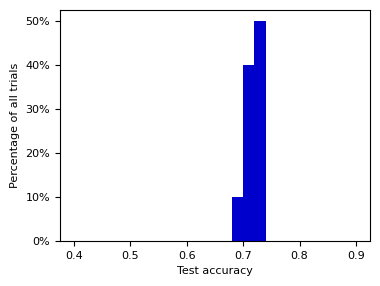

------------------------------ 
Training set:


,Mode,Share
0,Auto,67.7% (2.1%)
1,Walk,20.9% (2.1%)
2,Train,9.7% (0.4%)
3,Bike,1.7% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,69.5% (1.9%)
1,Walk,18.4% (1.9%)
2,Train,10.4% (0.4%)
3,Bike,1.7% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.153 (0.3),-0.199 (0.8),-0.603 (0.6),-0.973 (0.8)
4,auto_time,-0.465 (0.5),0.807 (0.8),1.584 (0.8),1.007 (0.7)
5,auto_cost,-0.69 (0.8),1.426 (1.3),1.534 (1.2),0.409 (1.3)
6,walk_time,0.385 (0.4),-1.534 (1.5),-0.891 (1.1),-0.84 (1.3)
7,train_time,0.48 (0.4),-1.438 (1.4),-2.22 (2.7),-1.555 (2.6)
8,train_cost,-0.239 (1.5),2.59 (2.8),-4.643 (3.2),-1.064 (2.1)
9,bike_time,-0.192 (0.5),0.565 (1.2),1.03 (1.3),0.742 (1.0)


------------------------------
Strong regularity = 0.9659
Weak regularity = 0.9922
------------------------------


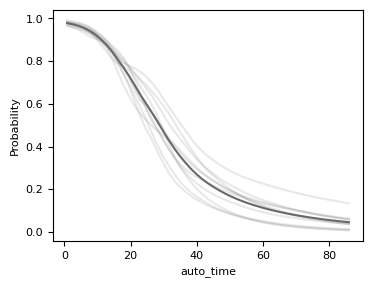

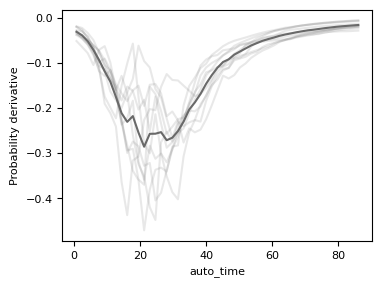

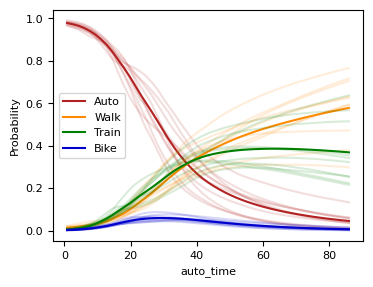

Penalty = 3e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7460, 71.7%
Model 2 : 0.7462, 71.7%
Model 3 : 0.7414, 71.0%
Model 4 : 0.7404, 71.0%
Model 5 : 0.7349, 73.0%
Model 6 : 0.7591, 71.3%
Model 7 : 0.7482, 71.7%
Model 8 : 0.7413, 73.0%
Model 9 : 0.7462, 71.7%
Model 10: 0.7406, 73.0%
------------------------------
Mean loss = 0.7444
Mean accuracy = 71.9%


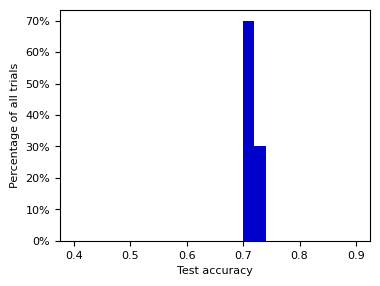

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.6% (1.8%)
1,Walk,20.4% (1.8%)
2,Train,9.3% (0.4%)
3,Bike,1.7% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.3% (1.7%)
1,Walk,18.0% (1.6%)
2,Train,9.9% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.167 (0.3),-0.29 (0.8),-0.677 (0.6),-0.994 (0.7)
4,auto_time,-0.3 (0.4),0.409 (0.6),1.243 (0.6),0.761 (0.5)
5,auto_cost,-0.297 (0.4),0.571 (1.0),0.852 (0.9),-0.131 (1.1)
6,walk_time,0.23 (0.3),-0.857 (0.9),-0.51 (0.7),-0.502 (0.9)
7,train_time,0.442 (0.4),-1.474 (1.3),-1.91 (2.1),-1.477 (2.2)
8,train_cost,-0.499 (1.6),2.244 (2.4),-3.196 (2.5),-0.809 (1.8)
9,bike_time,-0.181 (0.4),0.521 (1.0),0.948 (1.1),0.758 (0.9)


------------------------------
Strong regularity = 0.9159
Weak regularity = 0.9571
------------------------------


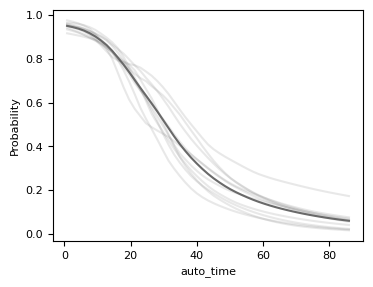

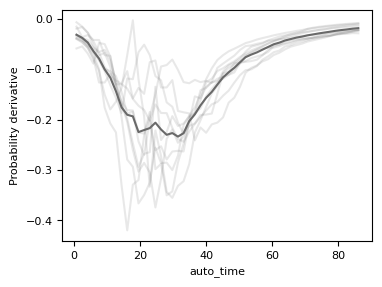

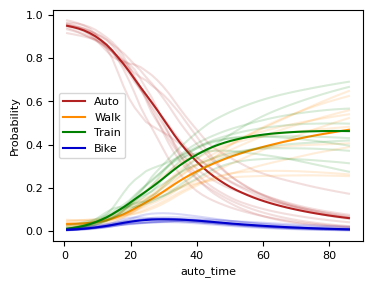

Penalty = 1e-05
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7464, 71.3%
Model 2 : 0.7450, 71.3%
Model 3 : 0.7412, 71.7%
Model 4 : 0.7432, 72.7%
Model 5 : 0.7353, 72.7%
Model 6 : 0.7591, 71.3%
Model 7 : 0.7501, 71.3%
Model 8 : 0.7433, 73.3%
Model 9 : 0.7468, 72.0%
Model 10: 0.7413, 73.0%
------------------------------
Mean loss = 0.7452
Mean accuracy = 72.1%


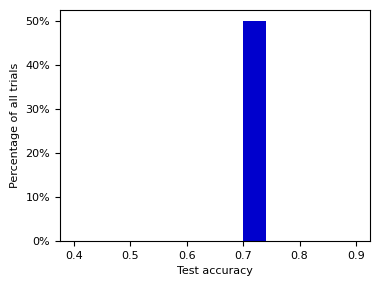

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.7% (1.8%)
1,Walk,20.4% (1.8%)
2,Train,9.2% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.7%)
1,Walk,18.0% (1.6%)
2,Train,9.9% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.173 (0.3),-0.323 (0.8),-0.721 (0.6),-1.024 (0.7)
4,auto_time,-0.261 (0.4),0.323 (0.6),1.187 (0.6),0.702 (0.5)
5,auto_cost,-0.202 (0.4),0.332 (0.9),0.686 (0.9),-0.274 (1.1)
6,walk_time,0.186 (0.3),-0.684 (0.7),-0.409 (0.6),-0.416 (0.8)
7,train_time,0.433 (0.4),-1.493 (1.4),-1.853 (2.1),-1.479 (2.2)
8,train_cost,-0.532 (1.6),2.16 (2.3),-2.923 (2.3),-0.737 (1.7)
9,bike_time,-0.173 (0.4),0.513 (0.9),0.929 (1.1),0.772 (0.9)


------------------------------
Strong regularity = 0.8785
Weak regularity = 0.9271
------------------------------


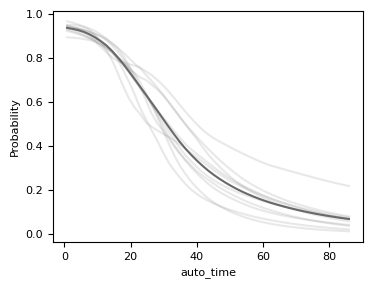

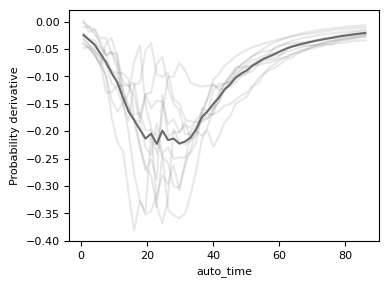

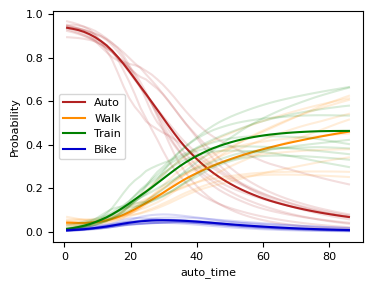

Penalty = 3e-06
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7469, 71.0%
Model 2 : 0.7464, 71.3%
Model 3 : 0.7419, 71.7%
Model 4 : 0.7436, 73.0%
Model 5 : 0.7361, 73.0%
Model 6 : 0.7582, 71.7%
Model 7 : 0.7494, 71.0%
Model 8 : 0.7442, 73.3%
Model 9 : 0.7467, 72.0%
Model 10: 0.7407, 73.3%
------------------------------
Mean loss = 0.7454
Mean accuracy = 72.1%


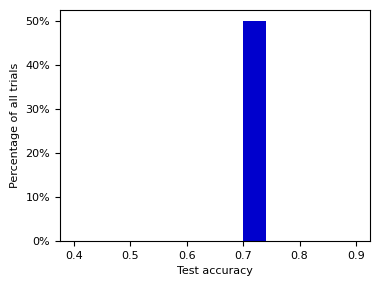

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.8% (1.7%)
1,Walk,20.3% (1.7%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.0% (1.6%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.173 (0.3),-0.31 (0.8),-0.716 (0.6),-0.985 (0.7)
4,auto_time,-0.242 (0.4),0.26 (0.5),1.138 (0.6),0.653 (0.5)
5,auto_cost,-0.163 (0.3),0.228 (0.9),0.588 (0.9),-0.318 (1.1)
6,walk_time,0.171 (0.3),-0.629 (0.6),-0.359 (0.6),-0.392 (0.7)
7,train_time,0.424 (0.4),-1.474 (1.3),-1.814 (2.1),-1.497 (2.2)
8,train_cost,-0.554 (1.5),2.235 (2.4),-2.792 (2.3),-0.583 (1.7)
9,bike_time,-0.171 (0.4),0.513 (0.9),0.922 (1.1),0.784 (1.0)


------------------------------
Strong regularity = 0.8607
Weak regularity = 0.9129
------------------------------


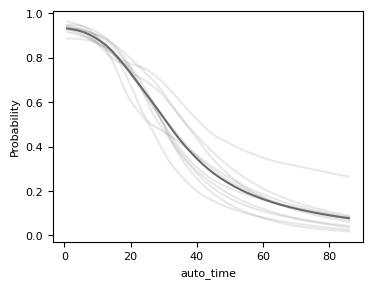

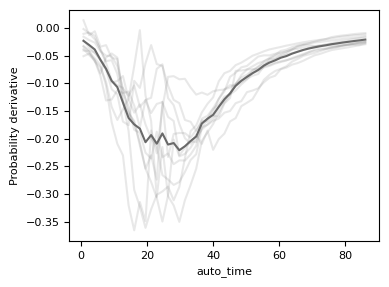

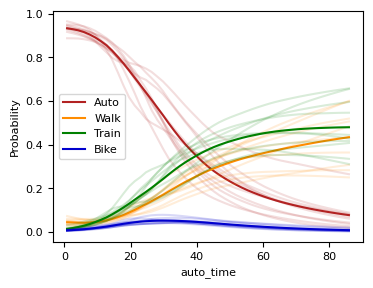

Penalty = 1e-06
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7464, 71.0%
Model 2 : 0.7461, 72.3%
Model 3 : 0.7412, 71.7%
Model 4 : 0.7439, 72.0%
Model 5 : 0.7358, 73.0%
Model 6 : 0.7580, 71.7%
Model 7 : 0.7495, 71.7%
Model 8 : 0.7448, 73.3%
Model 9 : 0.7482, 71.7%
Model 10: 0.7411, 73.3%
------------------------------
Mean loss = 0.7455
Mean accuracy = 72.2%


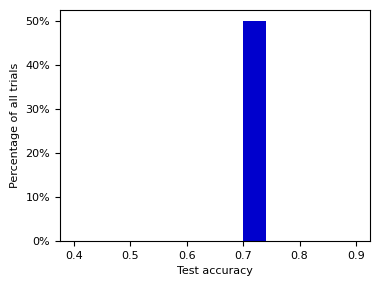

------------------------------ 
Training set:


,Mode,Share
0,Auto,68.8% (1.7%)
1,Walk,20.3% (1.7%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.0% (1.5%)
2,Train,9.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.176 (0.3),-0.325 (0.8),-0.726 (0.6),-0.994 (0.7)
4,auto_time,-0.241 (0.4),0.258 (0.5),1.139 (0.6),0.654 (0.5)
5,auto_cost,-0.15 (0.3),0.218 (0.9),0.564 (0.9),-0.345 (1.1)
6,walk_time,0.166 (0.2),-0.616 (0.6),-0.353 (0.6),-0.377 (0.7)
7,train_time,0.422 (0.4),-1.464 (1.3),-1.811 (2.1),-1.488 (2.2)
8,train_cost,-0.572 (1.5),2.258 (2.3),-2.75 (2.2),-0.572 (1.7)
9,bike_time,-0.168 (0.4),0.496 (0.9),0.91 (1.1),0.774 (0.9)


------------------------------
Strong regularity = 0.8576
Weak regularity = 0.9086
------------------------------


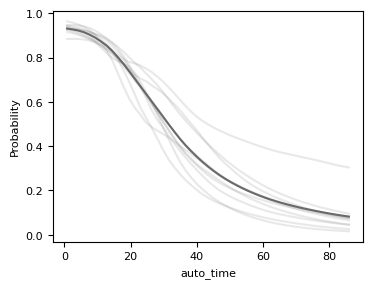

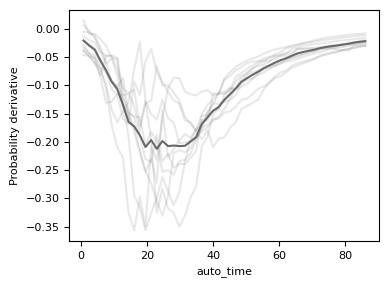

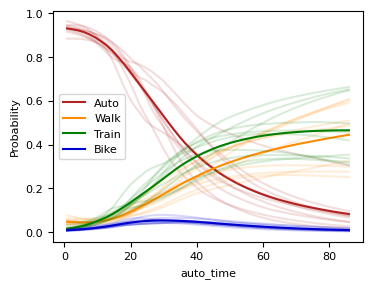

------------------------------ 
Model comparison:


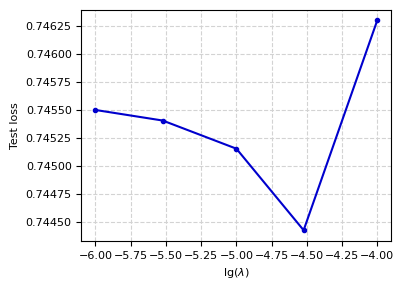

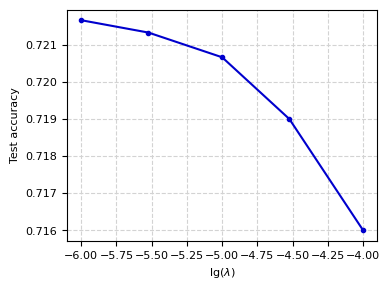

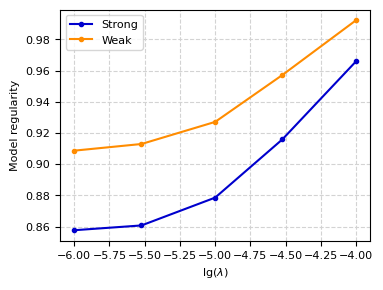

In [55]:
# With sum
result('prob', [1e-4, 3e-5, 1e-5, 3e-6, 1e-6])

In [ ]:
# With norm
# result('prob', [1e-1, 1e-2, 1e-3], False)

### Loss gradient regularization

Penalty = 0.063
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7393, 73.0%
Model 2 : 0.7450, 72.0%
Model 3 : 0.7489, 71.7%
Model 4 : 0.7545, 69.7%
Model 5 : 0.7460, 71.0%
Model 6 : 0.7491, 72.7%
Model 7 : 0.7483, 71.7%
Model 8 : 0.7571, 70.3%
Model 9 : 0.7473, 71.7%
Model 10: 0.7485, 72.0%
------------------------------
Mean loss = 0.7484
Mean accuracy = 71.6%


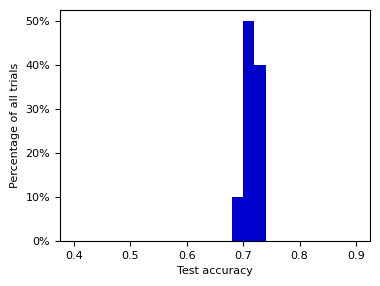

------------------------------ 
Training set:


,Mode,Share
0,Auto,73.5% (1.5%)
1,Walk,16.0% (1.5%)
2,Train,8.8% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,74.9% (1.3%)
1,Walk,14.2% (1.3%)
2,Train,9.2% (0.4%)
3,Bike,1.7% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.131 (0.3),-0.111 (1.0),-0.805 (0.8),-1.065 (0.9)
4,auto_time,-0.33 (0.4),1.028 (1.0),1.408 (0.7),0.921 (0.6)
5,auto_cost,-0.21 (0.4),0.29 (1.1),0.253 (1.3),-0.141 (1.6)
6,walk_time,0.183 (0.2),-1.155 (1.4),-0.457 (0.8),-0.703 (1.1)
7,train_time,0.414 (0.4),-1.29 (0.7),-2.003 (2.2),-1.364 (2.0)
8,train_cost,-0.063 (1.1),0.031 (2.4),-1.516 (1.6),-1.155 (1.5)
9,bike_time,-0.117 (0.3),0.568 (1.3),0.866 (1.2),0.776 (1.2)


------------------------------
Strong regularity = 0.8932
Weak regularity = 0.9415
------------------------------


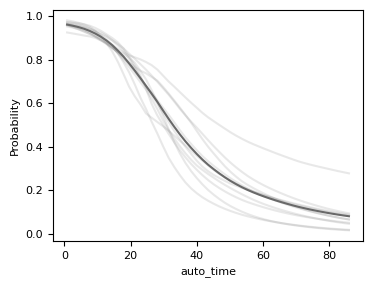

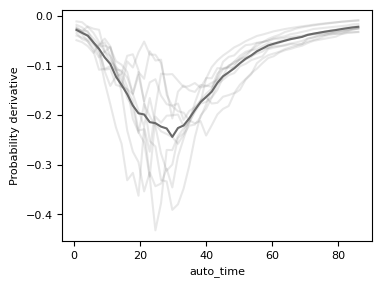

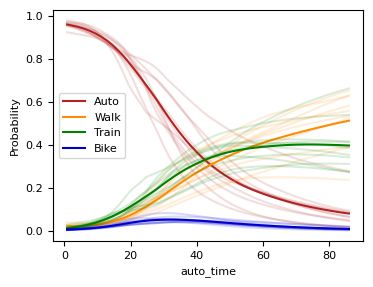

Penalty = 0.04
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7378, 71.7%
Model 2 : 0.7416, 73.3%
Model 3 : 0.7414, 73.0%
Model 4 : 0.7438, 71.3%
Model 5 : 0.7399, 72.7%
Model 6 : 0.7498, 72.0%
Model 7 : 0.7469, 73.3%
Model 8 : 0.7479, 71.0%
Model 9 : 0.7449, 73.3%
Model 10: 0.7429, 73.7%
------------------------------
Mean loss = 0.7437
Mean accuracy = 72.5%


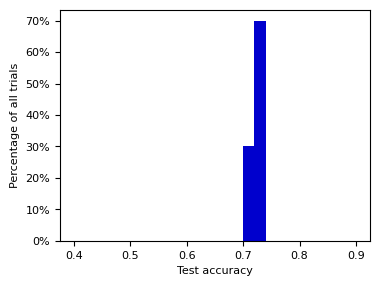

------------------------------ 
Training set:


,Mode,Share
0,Auto,71.4% (1.6%)
1,Walk,17.8% (1.6%)
2,Train,9.0% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,73.0% (1.5%)
1,Walk,15.8% (1.4%)
2,Train,9.5% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.153 (0.3),-0.151 (1.0),-0.768 (0.8),-1.082 (0.9)
4,auto_time,-0.313 (0.4),0.837 (1.0),1.391 (0.7),0.851 (0.6)
5,auto_cost,-0.255 (0.5),0.389 (1.1),0.2 (1.3),-0.13 (1.5)
6,walk_time,0.199 (0.2),-1.112 (1.3),-0.467 (0.9),-0.675 (1.1)
7,train_time,0.437 (0.4),-1.227 (0.8),-1.952 (2.2),-1.255 (1.8)
8,train_cost,-0.443 (1.3),0.956 (2.5),-1.306 (1.7),-0.934 (1.6)
9,bike_time,-0.128 (0.3),0.536 (1.3),0.881 (1.3),0.76 (1.2)


------------------------------
Strong regularity = 0.8741
Weak regularity = 0.9262
------------------------------


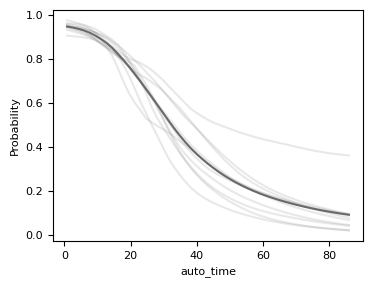

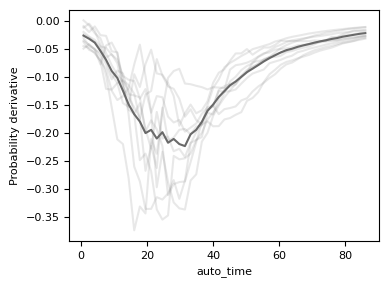

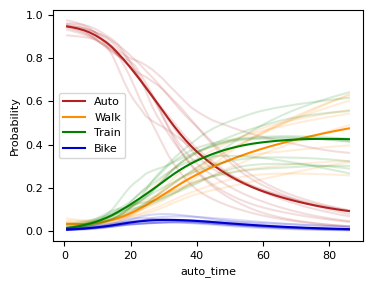

Penalty = 0.025
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7389, 71.0%
Model 2 : 0.7401, 72.3%
Model 3 : 0.7404, 73.0%
Model 4 : 0.7400, 72.3%
Model 5 : 0.7366, 73.3%
Model 6 : 0.7507, 71.3%
Model 7 : 0.7469, 72.3%
Model 8 : 0.7454, 71.7%
Model 9 : 0.7441, 72.3%
Model 10: 0.7425, 73.7%
------------------------------
Mean loss = 0.7426
Mean accuracy = 72.3%


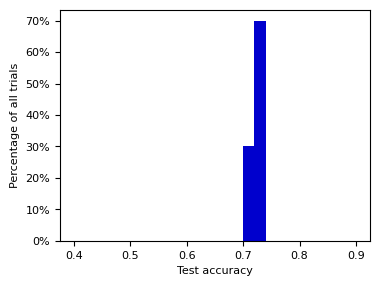

------------------------------ 
Training set:


,Mode,Share
0,Auto,70.4% (1.6%)
1,Walk,18.8% (1.6%)
2,Train,9.0% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,72.0% (1.5%)
1,Walk,16.6% (1.4%)
2,Train,9.6% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.161 (0.3),-0.336 (0.8),-0.722 (0.7),-1.014 (0.7)
4,auto_time,-0.237 (0.4),0.267 (0.6),1.116 (0.6),0.653 (0.5)
5,auto_cost,-0.141 (0.3),0.24 (0.9),0.595 (0.9),-0.315 (1.1)
6,walk_time,0.156 (0.2),-0.596 (0.6),-0.349 (0.6),-0.368 (0.7)
7,train_time,0.404 (0.4),-1.506 (1.3),-1.827 (2.0),-1.514 (2.2)
8,train_cost,-0.474 (1.4),2.058 (2.3),-2.633 (2.2),-0.628 (1.7)
9,bike_time,-0.166 (0.4),0.535 (1.0),0.922 (1.1),0.785 (1.0)


------------------------------
Strong regularity = 0.8648
Weak regularity = 0.9171
------------------------------


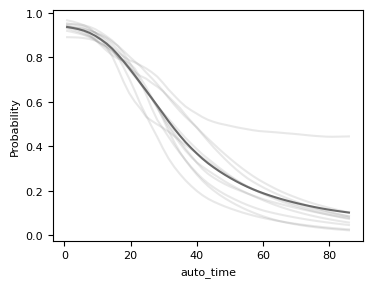

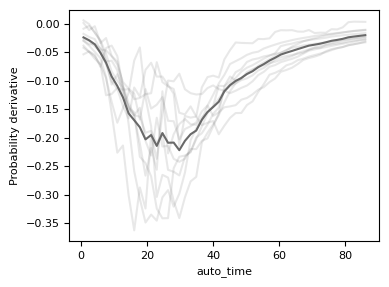

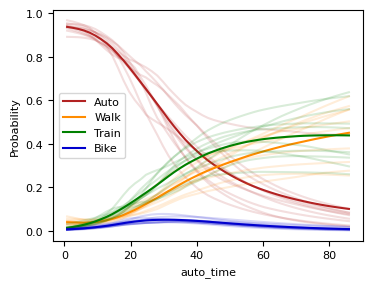

Penalty = 0.016
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7405, 71.3%
Model 2 : 0.7425, 72.0%
Model 3 : 0.7416, 73.3%
Model 4 : 0.7415, 72.7%
Model 5 : 0.7353, 73.3%
Model 6 : 0.7536, 71.3%
Model 7 : 0.7476, 72.3%
Model 8 : 0.7462, 72.0%
Model 9 : 0.7454, 72.3%
Model 10: 0.7387, 74.0%
------------------------------
Mean loss = 0.7433
Mean accuracy = 72.5%


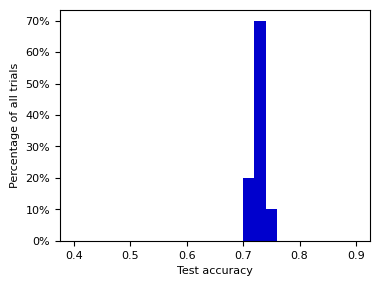

------------------------------ 
Training set:


,Mode,Share
0,Auto,69.7% (1.6%)
1,Walk,19.4% (1.6%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,71.4% (1.5%)
1,Walk,17.1% (1.5%)
2,Train,9.7% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.167 (0.3),-0.326 (0.8),-0.733 (0.6),-1.001 (0.7)
4,auto_time,-0.231 (0.4),0.245 (0.5),1.107 (0.6),0.64 (0.5)
5,auto_cost,-0.14 (0.3),0.229 (0.9),0.569 (0.9),-0.326 (1.1)
6,walk_time,0.158 (0.2),-0.608 (0.6),-0.349 (0.6),-0.384 (0.7)
7,train_time,0.409 (0.4),-1.488 (1.3),-1.812 (2.0),-1.499 (2.2)
8,train_cost,-0.514 (1.4),2.174 (2.3),-2.685 (2.2),-0.579 (1.7)
9,bike_time,-0.168 (0.4),0.526 (1.0),0.919 (1.1),0.791 (1.0)


------------------------------
Strong regularity = 0.8606
Weak regularity = 0.9126
------------------------------


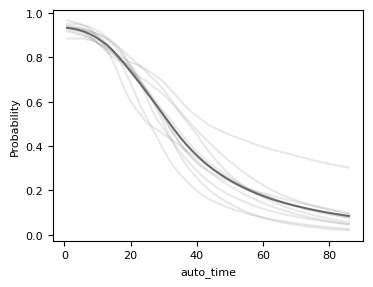

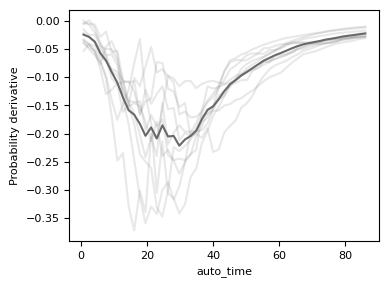

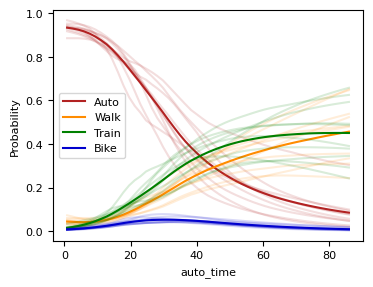

Penalty = 0.01
------------------------------ 
Test losses and accuracies:
Model 1 : 0.7429, 71.3%
Model 2 : 0.7453, 71.7%
Model 3 : 0.7413, 72.7%
Model 4 : 0.7421, 72.0%
Model 5 : 0.7360, 73.0%
Model 6 : 0.7554, 72.0%
Model 7 : 0.7481, 71.7%
Model 8 : 0.7446, 72.7%
Model 9 : 0.7469, 72.0%
Model 10: 0.7392, 73.7%
------------------------------
Mean loss = 0.7442
Mean accuracy = 72.3%


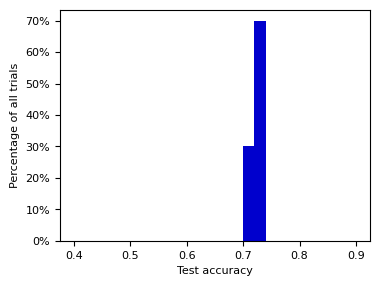

------------------------------ 
Training set:


,Mode,Share
0,Auto,69.4% (1.7%)
1,Walk,19.8% (1.6%)
2,Train,9.1% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Testing set:


,Mode,Share
0,Auto,71.0% (1.6%)
1,Walk,17.5% (1.5%)
2,Train,9.7% (0.4%)
3,Bike,1.8% (0.1%)


------------------------------ 
Elasticities:


,Input,Auto,Walk,Train,Bike
3,hhveh,0.17 (0.3),-0.328 (0.8),-0.758 (0.6),-1.002 (0.7)
4,auto_time,-0.23 (0.4),0.252 (0.6),1.109 (0.6),0.667 (0.5)
5,auto_cost,-0.145 (0.3),0.229 (0.9),0.575 (0.9),-0.318 (1.2)
6,walk_time,0.161 (0.2),-0.612 (0.6),-0.345 (0.6),-0.375 (0.7)
7,train_time,0.411 (0.3),-1.455 (1.3),-1.815 (2.1),-1.509 (2.2)
8,train_cost,-0.517 (1.5),2.127 (2.3),-2.685 (2.2),-0.607 (1.7)
9,bike_time,-0.166 (0.4),0.513 (0.9),0.904 (1.1),0.769 (0.9)


------------------------------
Strong regularity = 0.8564
Weak regularity = 0.9080
------------------------------


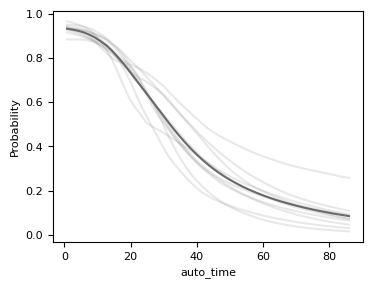

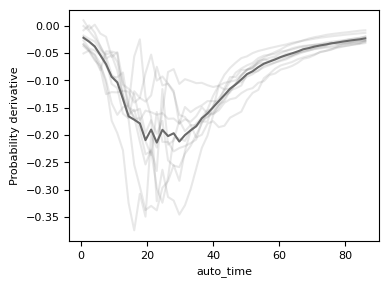

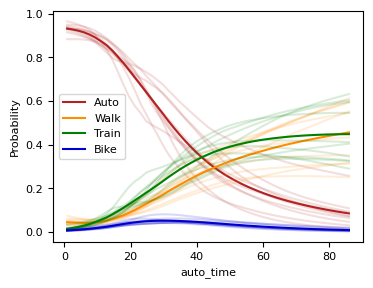

------------------------------ 
Model comparison:


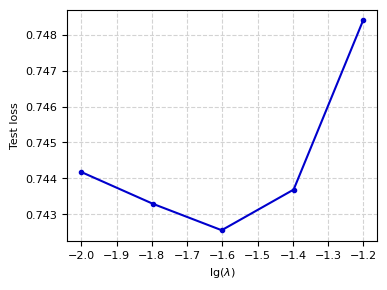

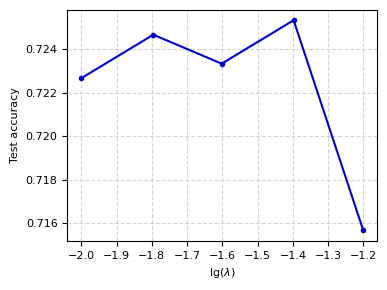

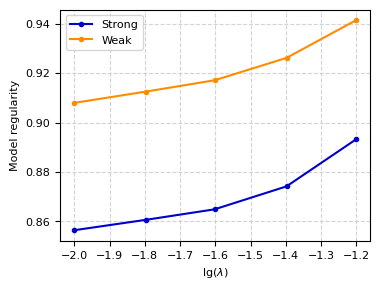

In [66]:
# With sum
result('loss', [.063, .04, .025, .016, .01])

In [ ]:
# With norm
# result('loss', [1e-1, 1e-2, 1e-3], False)